## Demographic Perspective

In [1]:
# Jupyter notebook: optional formatting extension
# %load_ext nb_black

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import os
import datetime
import math
from math import ceil

# Preprocessing
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.impute import KNNImputer

# Clustering
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, MeanShift, estimate_bandwidth
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import NearestNeighbors, LocalOutlierFactor

# Clustering evaluation
from sklearn.metrics import silhouette_score, silhouette_samples, davies_bouldin_score, calinski_harabasz_score

# Hierarchical clustering
from scipy.cluster.hierarchy import dendrogram, linkage

# Stats
from scipy.stats import chi2_contingency, stats
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.mosaicplot import mosaic

# Dimensionality reduction
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Model selection
from sklearn.model_selection import GridSearchCV

# Geospatial
from geopy.geocoders import Nominatim
from geopy.distance import geodesic
import geopandas as gpd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import plotly.express as px
import matplotlib.cm as cm


In [2]:
df_demographic = pd.read_csv("df_ready_for_clustering.csv")
df_demographic.head()

,PointsRedeemedRatio,FlightsWithCompanionsRatio,AvgDistancePerFlight,KMPerRedeemedPoint,UnredeemedPoints,LoyaltyIndex,CustomerSegment,HasBonus,TotalFlights,sr_jan,...,Education,Income,Marital Status,LoyaltyStatus,EnrollmentMonth,Time on Program,Cancelled,Reenroll,EnrollmentType,Customer Lifetime Value
0,0.387904,0.200000,2356.577778,25.786888,32446,709.589704,Moderate traveler and high redeemed,0,225,0.026667,...,Bachelor,82877.0,Married,Aurora,8,874,N,0,Standard,7919.20
1,0.553363,0.224490,1384.141224,18.077435,15141,418.130598,Low traveler and low redeemed,0,245,0.077551,...,College,0.0,Single,Nova,3,2122,N,0,Standard,2887.74
2,0.113362,0.241706,2047.539336,88.241585,38293,616.640254,Moderate traveler and low redeemed,0,211,0.094787,...,College,0.0,Divorced,Nova,7,884,N,0,Standard,2838.07
3,0.354092,0.157407,3375.941667,28.248369,23544,1014.088728,High traveler and high redeemed,0,108,0.000000,...,Bachelor,42837.0,Married,Star,8,1242,N,0,Standard,4170.57
4,0.253580,0.276243,2373.649171,39.448214,32058,714.181936,Moderate traveler and high redeemed,0,181,0.022099,...,Bachelor,80979.0,Divorced,Star,1,1816,N,0,Standard,6622.05


In [3]:
df_demographic.columns

Index(['PointsRedeemedRatio', 'FlightsWithCompanionsRatio',
       'AvgDistancePerFlight', 'KMPerRedeemedPoint', 'UnredeemedPoints',
       'LoyaltyIndex', 'CustomerSegment', 'HasBonus', 'TotalFlights', 'sr_jan',
       'sr_feb', 'sr_mar', 'sr_apr', 'sr_may', 'sr_jun', 'sr_jul', 'sr_aug',
       'sr_sep', 'sr_oct', 'sr_nov', 'sr_dec', 'Province or State',
       'Education', 'Income', 'Marital Status', 'LoyaltyStatus',
       'EnrollmentMonth', 'Time on Program', 'Cancelled', 'Reenroll',
       'EnrollmentType', 'Customer Lifetime Value'],
      dtype='object')

In [4]:
# Now choose for df_demographic the features you think are the best for clustering
features_demographic = [
     'Province or State', 'Education', 'Income', 'Marital Status']

df_demographic = df_demographic[features_demographic]
df_demographic.head()

,Province or State,Education,Income,Marital Status
0,Alberta,Bachelor,82877.0,Married
1,Ontario,College,0.0,Single
2,British Columbia,College,0.0,Divorced
3,British Columbia,Bachelor,42837.0,Married
4,Ontario,Bachelor,80979.0,Divorced


In [5]:
df_demographic.dtypes

Province or State     object
Education             object
Income               float64
Marital Status        object
dtype: object

In [6]:
# Transform Education and Marital Status into numerical values using OneHotEncoding 
# Use One Hot Encoder but do not separate from the dataframe yet

ohe = OneHotEncoder(sparse_output=False, drop='first')
ohe_features = ohe.fit_transform(df_demographic[['Education', 'Marital Status']])
ohe_feature_names = ohe.get_feature_names_out(['Education', 'Marital Status'])
df_ohe = pd.DataFrame(ohe_features, columns=ohe_feature_names)
df_demographic.reset_index(drop=True, inplace=True)
df_demographic = pd.concat([df_demographic.drop(columns=['Education', 'Marital Status']), df_ohe], axis=1)
df_demographic.head()


,Province or State,Income,Education_College,Education_Doctor,Education_High School or Below,Education_Master,Marital Status_Married,Marital Status_Single
0,Alberta,82877.0,0.0,0.0,0.0,0.0,1.0,0.0
1,Ontario,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,British Columbia,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,British Columbia,42837.0,0.0,0.0,0.0,0.0,1.0,0.0
4,Ontario,80979.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
# Now for Province or State, use Label Encoding
le = LabelEncoder()
df_demographic['Province or State'] = le.fit_transform(df_demographic['Province or State'])
df_demographic.head()


,Province or State,Income,Education_College,Education_Doctor,Education_High School or Below,Education_Master,Marital Status_Married,Marital Status_Single
0,0,82877.0,0.0,0.0,0.0,0.0,1.0,0.0
1,6,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,1,42837.0,0.0,0.0,0.0,0.0,1.0,0.0
4,6,80979.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
# Now use StandardScaler to scale the data 
scaler = StandardScaler()
df_demographic_scaled = scaler.fit_transform(df_demographic)
df_demographic_scaled = pd.DataFrame(df_demographic_scaled, columns=df_demographic.columns)
df_demographic_scaled.head()

,Province or State,Income,Education_College,Education_Doctor,Education_High School or Below,Education_Master,Marital Status_Married,Marital Status_Single
0,-1.532396,1.486972,-0.582413,-0.213725,-0.221031,-0.176733,0.847482,-0.605001
1,0.513872,-1.243288,1.716995,-0.213725,-0.221031,-0.176733,-1.179967,1.652889
2,-1.191352,-1.243288,1.716995,-0.213725,-0.221031,-0.176733,-1.179967,-0.605001
3,-1.191352,0.167914,-0.582413,-0.213725,-0.221031,-0.176733,0.847482,-0.605001
4,0.513872,1.424445,-0.582413,-0.213725,-0.221031,-0.176733,-1.179967,-0.605001


## Hierarchical Clustering

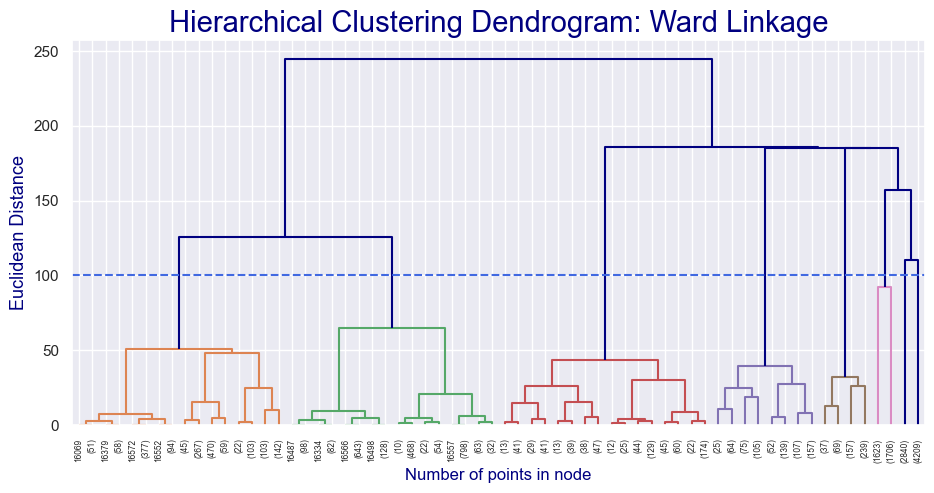

In [10]:
# Plot the corresponding dendrogram
from scipy.cluster.hierarchy import linkage
# setting distance_threshold=0 and n_clusters=None ensures we compute the full tree
distance = 'euclidean' 
n_clusters = None 

linkage_matrix= linkage(df_demographic_scaled, method="ward") 
sns.set()
fig = plt.figure(figsize=(11,5))
# The Dendrogram parameters need to be tuned
Y_THRESHOLD = 100 
dendrogram(linkage_matrix, truncate_mode='level', p=5, color_threshold=Y_THRESHOLD, above_threshold_color='navy')
    # You can play with 'truncate_mode' and 'p' define what level the dendrogram shows
    # above_threshold_color='k' forces black color for the lines above the threshold)
plt.hlines(Y_THRESHOLD, 0, 1000, colors="royalblue", linestyles="dashed")
plt.title(f'Hierarchical Clustering Dendrogram: Ward Linkage', fontsize=21, color='navy')
plt.xlabel('Number of points in node', color='navy')
plt.ylabel(f'{distance.title()} Distance', fontsize=13, color='navy')
plt.show()

In [13]:
linkage = "ward" 
distance = "euclidean" 
n_clusters = 4
hclust = AgglomerativeClustering(linkage=linkage, metric=distance, n_clusters=n_clusters)

hc_labels4 = hclust.fit_predict(df_demographic_scaled)

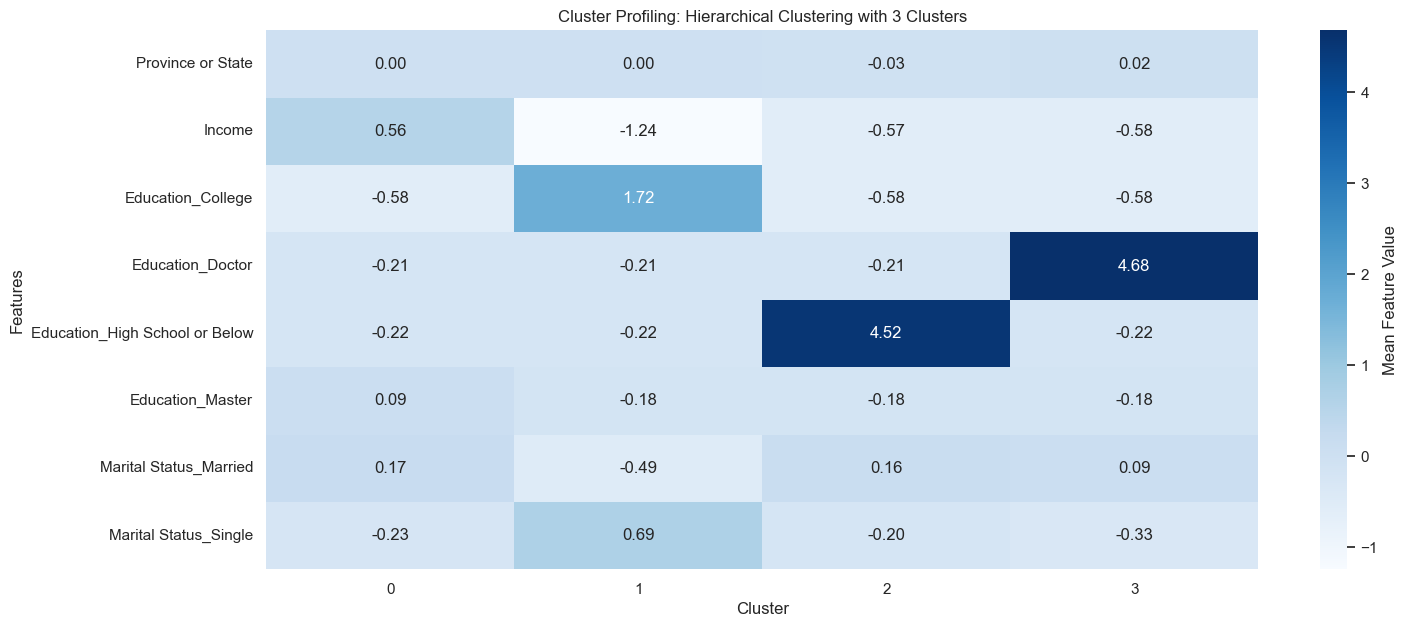

In [14]:
X = df_demographic_scaled.copy()
X['labels'] = hc_labels4

cluster_means = X.groupby('labels')[df_demographic_scaled.columns].mean().T

plt.figure(figsize=(16,7))
sns.heatmap(
    cluster_means,
    cmap="Blues",
    annot=True,
    fmt=".2f",
    cbar_kws={'label': 'Mean Feature Value'}
)
plt.xlabel("Cluster")
plt.ylabel("Features")
plt.title("Cluster Profiling: Hierarchical Clustering with 3 Clusters")
plt.yticks(rotation=0)
plt.show()


In [15]:
linkage = "ward" 
distance = "euclidean" 
n_clusters = 3
hclust = AgglomerativeClustering(linkage=linkage, metric=distance, n_clusters=n_clusters)

hc_labels3 = hclust.fit_predict(df_demographic_scaled)

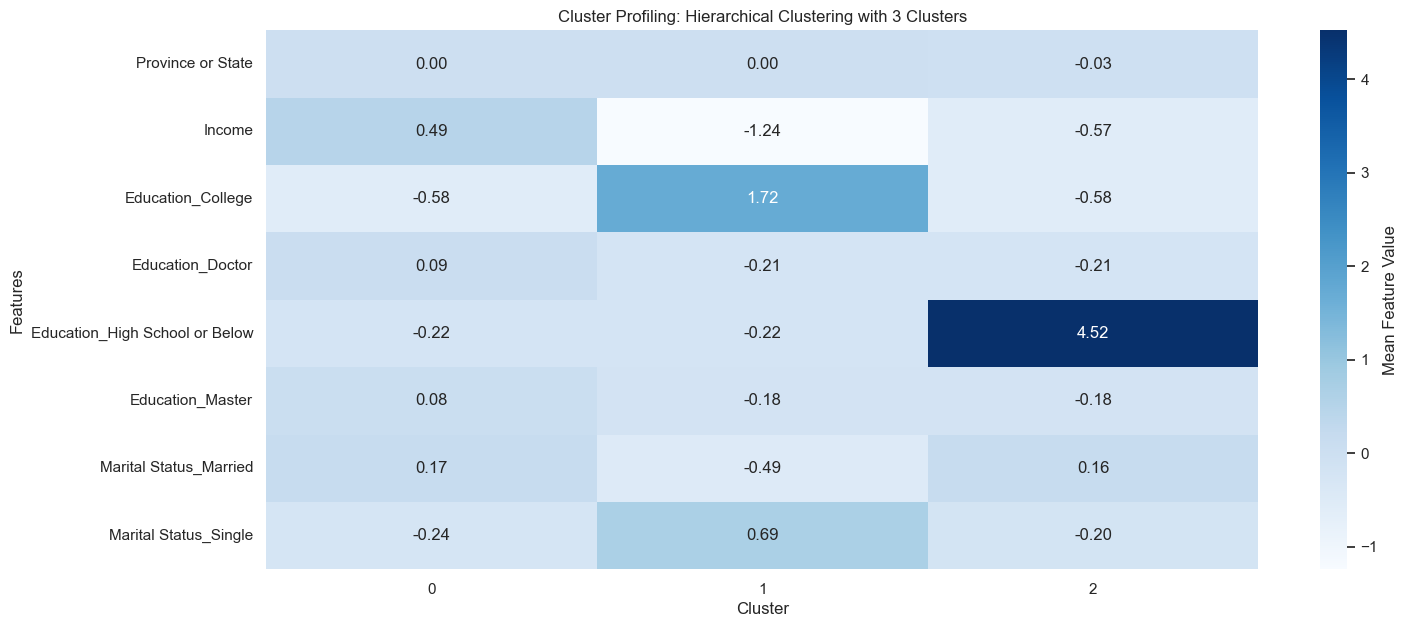

In [16]:
X = df_demographic_scaled.copy()
X['labels'] = hc_labels3

cluster_means = X.groupby('labels')[df_demographic_scaled.columns].mean().T

plt.figure(figsize=(16,7))
sns.heatmap(
    cluster_means,
    cmap="Blues",
    annot=True,
    fmt=".2f",
    cbar_kws={'label': 'Mean Feature Value'}
)
plt.xlabel("Cluster")
plt.ylabel("Features")
plt.title("Cluster Profiling: Hierarchical Clustering with 3 Clusters")
plt.yticks(rotation=0)
plt.show()


In [17]:
linkage = "ward" 
distance = "euclidean" 
n_clusters = 5
hclust = AgglomerativeClustering(linkage=linkage, metric=distance, n_clusters=n_clusters)

hc_labels5 = hclust.fit_predict(df_demographic_scaled)

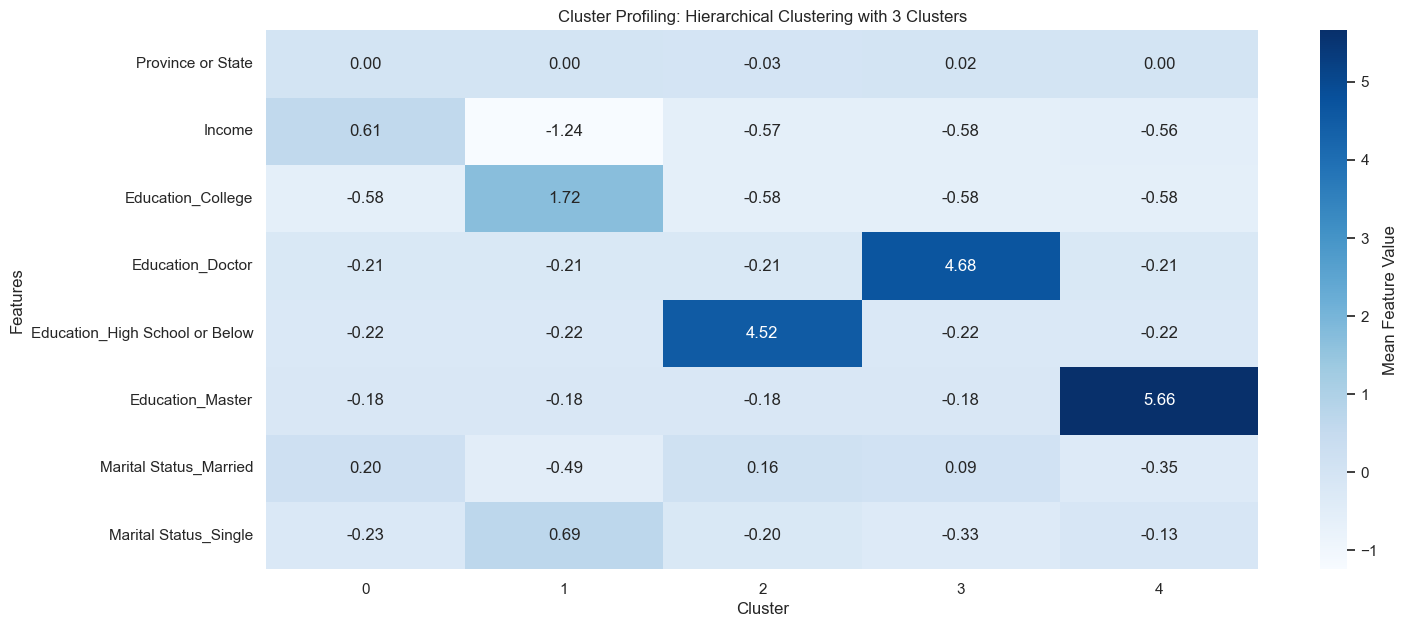

In [18]:
X = df_demographic_scaled.copy()
X['labels'] = hc_labels5

cluster_means = X.groupby('labels')[df_demographic_scaled.columns].mean().T

plt.figure(figsize=(16,7))
sns.heatmap(
    cluster_means,
    cmap="Blues",
    annot=True,
    fmt=".2f",
    cbar_kws={'label': 'Mean Feature Value'}
)
plt.xlabel("Cluster")
plt.ylabel("Features")
plt.title("Cluster Profiling: Hierarchical Clustering with 3 Clusters")
plt.yticks(rotation=0)
plt.show()


## KMeans

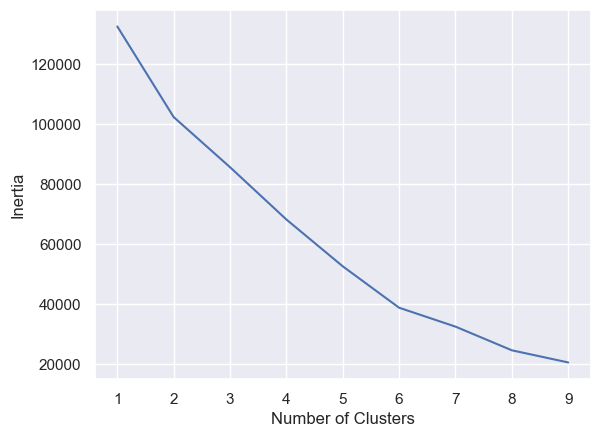

In [19]:
# Lets use the elbow method to find the best number of clusters

n_clusters = range(1, 10)
sse2 = []

for k in n_clusters:
    km = KMeans(n_clusters=k, init = "k-means++", max_iter=300, n_init=10)
    km.fit(df_demographic_scaled)
    sse2.append(km.inertia_)

plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.plot(n_clusters, sse2)  
plt.show()

cluster,0,1,2,3,4
Province or State,-0.008240,-0.882428,0.749749,0.011129,-0.029061
Income,-1.243288,0.329526,0.628150,-0.488238,-0.573372
Education_College,1.716995,-0.582413,-0.582413,0.705577,-0.582413
Education_Doctor,-0.213725,0.496639,-0.213725,-0.128189,-0.213725
Education_High School or Below,-0.221031,-0.221031,-0.221031,-0.221031,4.524258
Education_Master,-0.176733,0.337582,-0.174509,-0.032558,-0.176733
Marital Status_Married,0.429568,0.381214,0.469195,-1.179967,0.162036
Marital Status_Single,-0.605001,-0.597930,-0.605001,1.652889,-0.204313


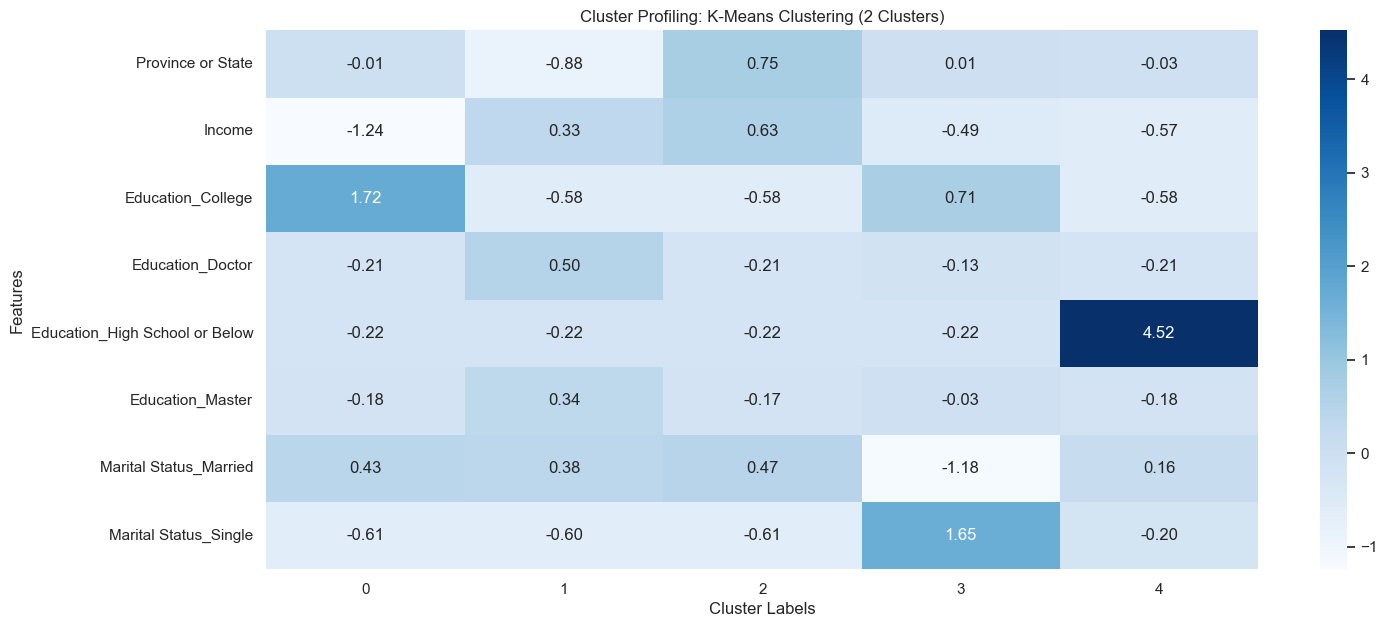

In [20]:
km = KMeans(n_clusters=5, init="k-means++", random_state=94)
km_labels_5 = km.fit_predict(df_demographic_scaled)

df_value_based_with_clusters = df_demographic_scaled.copy()
df_value_based_with_clusters['cluster'] = km_labels_5

cluster_profile_orig = df_value_based_with_clusters.groupby('cluster').mean()

display(cluster_profile_orig.T)

plt.figure(figsize=(16,7))
sns.heatmap(cluster_profile_orig.T, cmap="Blues", annot=True, fmt=".2f")
plt.title("Cluster Profiling: K-Means Clustering (2 Clusters)")
plt.xlabel("Cluster Labels")
plt.ylabel("Features")
plt.show()


cluster,0,1,2,3,4,5
Province or State,-0.008240,-1.023858,0.758832,0.012599,-0.029061,0.015023
Income,-1.243288,0.492565,0.617793,-0.485489,-0.573372,-0.582091
Education_College,1.716995,-0.582413,-0.582413,0.736002,-0.582413,-0.582413
Education_Doctor,-0.213725,-0.213725,-0.213725,-0.213725,-0.213725,4.678917
Education_High School or Below,-0.221031,-0.221031,-0.221031,-0.221031,4.524258,-0.221031
Education_Master,-0.176733,0.454078,-0.176733,-0.062567,-0.176733,-0.176733
Marital Status_Married,0.429568,0.397112,0.468236,-1.179967,0.162036,0.094189
Marital Status_Single,-0.605001,-0.591053,-0.605001,1.652889,-0.204313,-0.327443


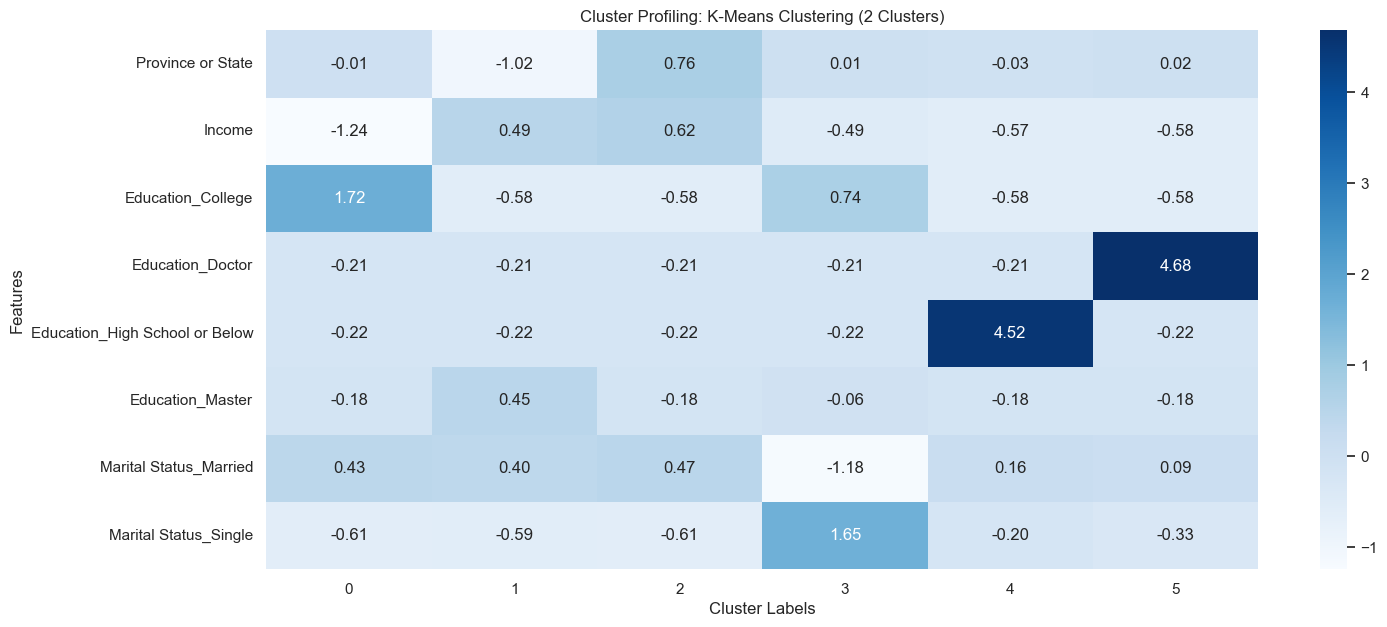

In [21]:
km = KMeans(n_clusters=6, init="k-means++", random_state=94)
km_labels_6 = km.fit_predict(df_demographic_scaled)

df_value_based_with_clusters = df_demographic_scaled.copy()
df_value_based_with_clusters['cluster'] = km_labels_6

cluster_profile_orig = df_value_based_with_clusters.groupby('cluster').mean()

display(cluster_profile_orig.T)

plt.figure(figsize=(16,7))
sns.heatmap(cluster_profile_orig.T, cmap="Blues", annot=True, fmt=".2f")
plt.title("Cluster Profiling: K-Means Clustering (2 Clusters)")
plt.xlabel("Cluster Labels")
plt.ylabel("Features")
plt.show()


In [22]:
# Features used for clustering
X = df_demographic_scaled.copy()


# Compute metrics for KMeans with 4 clusters
kmeans_5_silhouette = silhouette_score(X, km_labels_5)
kmeans_5_calinski_harabasz = calinski_harabasz_score(X, km_labels_5)
kmeans_5_davies_bouldin = davies_bouldin_score(X, km_labels_5)

# Compute metrics for KMeans with 6 clusters
kmeans_6_silhouette = silhouette_score(X, km_labels_6)
kmeans_6_calinski_harabasz = calinski_harabasz_score(X, km_labels_6)
kmeans_6_davies_bouldin = davies_bouldin_score(X, km_labels_6)
# Create a comparison table
comparison_table = pd.DataFrame({
    "Clustering Method": ["Hierarchical (4 Clusters)", "Hierarchical (3 Clusters)", "K-Means (5 Clusters)", "K-Means (5 Clusters)", "K-Means (6 Clusters)"],
    "Silhouette Score": [silhouette_score(X, hc_labels4), silhouette_score(X, hc_labels3), silhouette_score(X, km_labels_5), kmeans_5_silhouette, kmeans_6_silhouette],
    "Calinski-Harabasz Index": [calinski_harabasz_score(X, hc_labels4), calinski_harabasz_score(X, hc_labels3), calinski_harabasz_score(X, km_labels_5), kmeans_5_calinski_harabasz, kmeans_6_calinski_harabasz],
    "Davies-Bouldin Index": [davies_bouldin_score(X, hc_labels4), davies_bouldin_score(X, hc_labels3), davies_bouldin_score(X, km_labels_5), kmeans_5_davies_bouldin, kmeans_6_davies_bouldin]
})
comparison_table.head(6)

,Clustering Method,Silhouette Score,Calinski-Harabasz Index,Davies-Bouldin Index
0,Hierarchical (4 Clusters),0.409123,5217.961564,0.928599
1,Hierarchical (3 Clusters),0.358654,4582.382073,1.079969
2,K-Means (5 Clusters),0.327188,4223.409631,1.339852
3,K-Means (5 Clusters),0.327188,4223.409631,1.339852
4,K-Means (6 Clusters),0.382604,5559.391006,1.040660


### Conclusion 


Hierarchical with 4 clusters are the method who achieves the best results.

We will continue with this method, since in terms of visualization has a great division regarding outliers.

## Profilling

In [25]:
hr4 = AgglomerativeClustering(n_clusters=4, metric='euclidean', linkage='ward')
hr4_labels = hr4.fit_predict(df_demographic_scaled)

print(f"  Cluster 0: {np.sum(hr4_labels == 0):,} customers")
print(f"  Cluster 1: {np.sum(hr4_labels == 1):,} customers")
print(f"  Cluster 2: {np.sum(hr4_labels == 2):,} customers")
print(f"  Cluster 3: {np.sum(hr4_labels == 3):,} customers")

  Cluster 0: 10,880 customers
  Cluster 1: 4,198 customers
  Cluster 2: 772 customers
  Cluster 3: 724 customers


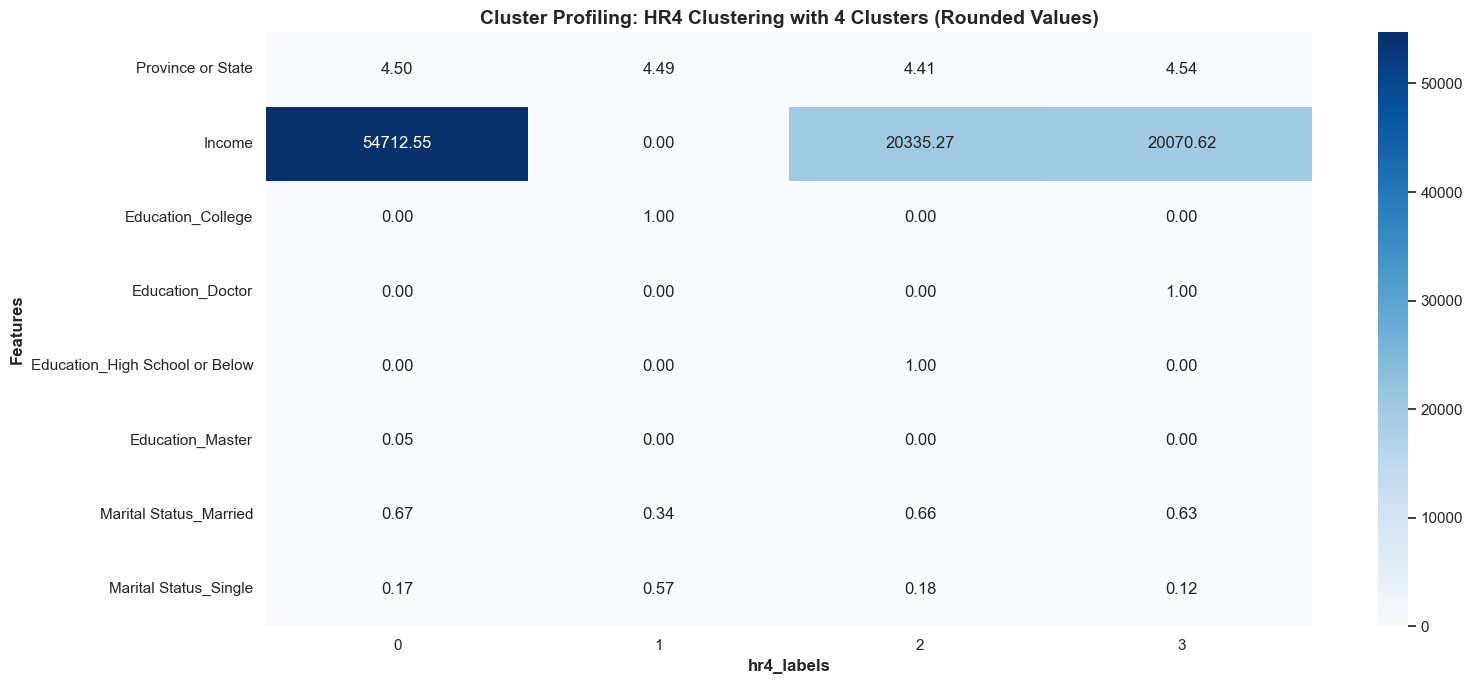

In [27]:
# add hr4 cluster labels to df
df_demographic_scaled['hr4_labels'] = hr4_labels

features_to_cluster = df_demographic_scaled.columns.drop('hr4_labels')
# Inverse transform to get original scale
df_original_scale = pd.DataFrame(
    scaler.inverse_transform(df_demographic_scaled[features_to_cluster]),
    columns=features_to_cluster,
    index=df_demographic_scaled.index
)

# Add cluster labels
df_original_scale['hr4_labels'] = df_demographic_scaled['hr4_labels'].values
# Calculate mean per cluster (in original scale)
cluster_profile_original = df_original_scale.groupby('hr4_labels')[features_to_cluster].mean()


plt.figure(figsize=(16, 7))
sns.heatmap(cluster_profile_original.T, cmap="Blues", annot=True, fmt=".2f")
plt.title("Cluster Profiling: HR4 Clustering with 4 Clusters (Rounded Values)", 
          fontweight='bold', fontsize=14)
plt.xlabel("hr4_labels", fontweight='bold')
plt.ylabel("Features", fontweight='bold')
plt.tight_layout()
plt.show()


In [28]:
# Radar Chart for Cluster Profiling
# Radar
import plotly.graph_objects as go
categories = list(cluster_profile_original.columns)
fig = go.Figure()
for i in cluster_profile_original.index:
    fig.add_trace(go.Scatterpolar(
        r=cluster_profile_original.loc[i].values,
        theta=categories,
        fill='toself',
        name=f'Cluster {i}'
    ))
fig.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[cluster_profile_original.min().min(), cluster_profile_original.max().max()]
        )),
    showlegend=True,
    title="Radar Chart for Cluster Profiling (HR4 Clustering with 4 Clusters)"
)
fig.show()
